# Segundo trabalho prático
### Aprendizado de máquina

> Alessandra Faria Abreu

# Preparação do ambiente

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import roc_curve,auc

from sklearn import tree


from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link =  "https://drive.google.com/open?id=1K3C_Vs3bANhr9CEWJQkz-nw9tLaMtace" 
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('tic-tac-toe.data')  


1K3C_Vs3bANhr9CEWJQkz-nw9tLaMtace


#Importando os dados 

In [3]:
df = pd.read_csv('tic-tac-toe.data')#, sep=',', decimal='.', encoding = "UTF-8"

In [4]:
df.head()

x x.1 x.2 x.3  o o.1 x.4 o.2 o.3  positive
0  x   x   x   x  o   o   o   x   o  positive
1  x   x   x   x  o   o   o   o   x  positive
2  x   x   x   x  o   o   o   b   b  positive
3  x   x   x   x  o   o   b   o   b  positive
4  x   x   x   x  o   o   b   b   o  positive

#Pré-Processamento da base de dados

## Análise estatística

In [5]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

resumetable(df)

Dataset Shape: (957, 10)


Name  dtypes  Missing  Uniques First Value Second Value Third Value  \
0         x  object        0        3           x            x           x   
1       x.1  object        0        3           x            x           x   
2       x.2  object        0        3           x            x           x   
3       x.3  object        0        3           x            x           x   
4         o  object        0        3           o            o           o   
5       o.1  object        0        3           o            o           o   
6       x.4  object        0        3           o            o           o   
7       o.2  object        0        3           x            o           b   
8       o.3  object        0        3           o            x           b   
9  positive  object        0        2    positive     positive    positive   

   Entropy  
0     1.53  
1     1.57  
2     1.53  
3     1.57  
4     1.47  
5     1.56  
6     1.53  
7     1.56  
8     1.53  
9     0.93

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


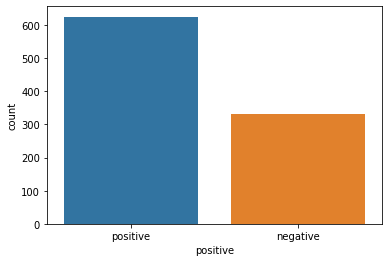

In [6]:
#Verificando o balanceamento dos dados
sns.countplot(df['positive'])

## Transformação/Encode dos dados

In [7]:
#renomeando as colunas
df.rename(columns={'x': 'TLS',
                   'x.1':'TMS',
                   'x.2':'TRS',
                   'x.3':'MLS',
                   'o':'MMS',
                   'o.1':'MRS', 
                   'x.4':'BLS',
                   'o.2':'BMS',
                   'o.3':'BRS',
                   'positive': 'classes'}, inplace=True)
df.head()

TLS TMS TRS MLS MMS MRS BLS BMS BRS   classes
0   x   x   x   x   o   o   o   x   o  positive
1   x   x   x   x   o   o   o   o   x  positive
2   x   x   x   x   o   o   o   b   b  positive
3   x   x   x   x   o   o   b   o   b  positive
4   x   x   x   x   o   o   b   b   o  positive

### Convertendo os dados para o tipo numérico

*   x = 2; 
*   o = 1; 
*   b = 0.

classes
*   1 = positive
*   0 = negative

In [8]:
encode = LabelEncoder()

df['TLS'] = encode.fit_transform(df['TLS'])
df['TMS'] = encode.fit_transform(df['TMS'])
df['TRS'] = encode.fit_transform(df['TRS'])
df['MLS'] = encode.fit_transform(df['MLS'])
df['MMS'] = encode.fit_transform(df['MMS'])
df['MRS'] = encode.fit_transform(df['MRS'])
df['BLS'] = encode.fit_transform(df['BLS'])
df['BMS'] = encode.fit_transform(df['BMS'])
df['BRS'] = encode.fit_transform(df['BRS'])
df['classes'] = encode.fit_transform(df['classes'])

df.head()

TLS  TMS  TRS  MLS  MMS  MRS  BLS  BMS  BRS  classes
0    2    2    2    2    1    1    1    2    1        1
1    2    2    2    2    1    1    1    1    2        1
2    2    2    2    2    1    1    1    0    0        1
3    2    2    2    2    1    1    0    1    0        1
4    2    2    2    2    1    1    0    0    1        1

# Execução dos modelos

## Validação cruzada k-fold 
com k igual a 5.

ℹ [Documentação oficial](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)


In [9]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

X, y = df[["TLS","TMS","TRS","MLS","MMS","MRS","BLS","BMS","BRS"]].values, df[["classes"]].values

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)


## Metricas 

**error**

Calcula a taxa de erro de um classificador fraco m. Argumentos:
* y: valor alvo real
* y_pred: valor previsto pelo classificador fraco
* w_i: pesos individuais para cada observação

**alpha**

Calcula o peso de um classificador fraco m na votação majoritária do classificador final. Isso é chamado
     alfa no capítulo 10.1 de Os Elementos da Aprendizagem Estatística Argumentos:
* erro: taxa de erro do classificador fraco m

**update_weights**

Atualiza os pesos individuais w_i após uma iteração de reforço. Argumentos:
* w_i: pesos individuais para cada observação
* y: valor alvo real
* y_pred: valor previsto pelo classificador fraco
* alfa: peso do classificador fraco usado para estimar y_pred

**Acurácia**

Representa  a fração das previsões que nosso modelo acertou.

**Precisão**

Representa a proporção de indentificação positiva estava realmente correta

**Recall**

Representa a proporção de positivos reais foi indetificado corretamente

In [11]:
def compute_error(y, y_pred, w_i):

    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):

    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
   
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

def printCM(Y_test, predictions):
    cm = confusion_matrix(Y_test, predictions)
    acc_score = accuracy_score(Y_test, predictions)
    prec_score = precision_score(Y_test, predictions, average='weighted')
    
    print ('Confusion Matrix : ')
    print (cm)
    print
    
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])

    actual_yes = fn+tp
    actual_no = tn+fp
    predicted_yes = fp+tp
    predicted_no = tn+fn

    total = float(len(df))
    print ('Total : '+ str(total))

    print ('Acurácia : ' + str(acc_score))

    misclassification_rate = round((fp+fn)/total,3) 
    print ('Misclassification rate : ' +str(misclassification_rate))

    true_positive = round(tp/actual_yes,3) 
    print ('True positives : ' +str(true_positive))

    false_positive = round(fp/actual_no,3) 
    print ('False positives : ' +str(false_positive))

    specificity = round(tn/actual_no,3) 
    print ('Specificity : ' +str(specificity))

    print ('Precision : ' +str(prec_score))

    prevalence = round(actual_yes/total,3) 
    print ('Prevalence : ' +str(prevalence))
    
    recall = round(tp / (tp + fn), 3)
    print ('Recall : ' +str(recall))
    
    return acc_score, prec_score, recall

## AdaBoost
 

O AdaBoost funciona adaptando iterativamente duas séries de pesos relacionadas, uma anexada aos pontos de dados e a outra aos próprios alunos. Os pontos de dados classificados incorretamente recebem pesos maiores para o próximo aluno na sequência. Dessa forma, os futuros alunos estarão mais propensos a se concentrar nesses pontos de dados. Ao final da sequência, os aprendizes que fizerem melhores previsões, principalmente nos pontos de dados mais resistentes à classificação correta, recebem mais peso na "votação" final que determina a previsão do ensemble.
Suponha que temos um problema de classificação binária e representamos as duas classes com 1 e -1. (Este é o padrão para descrever o algoritmo do AdaBoost.)

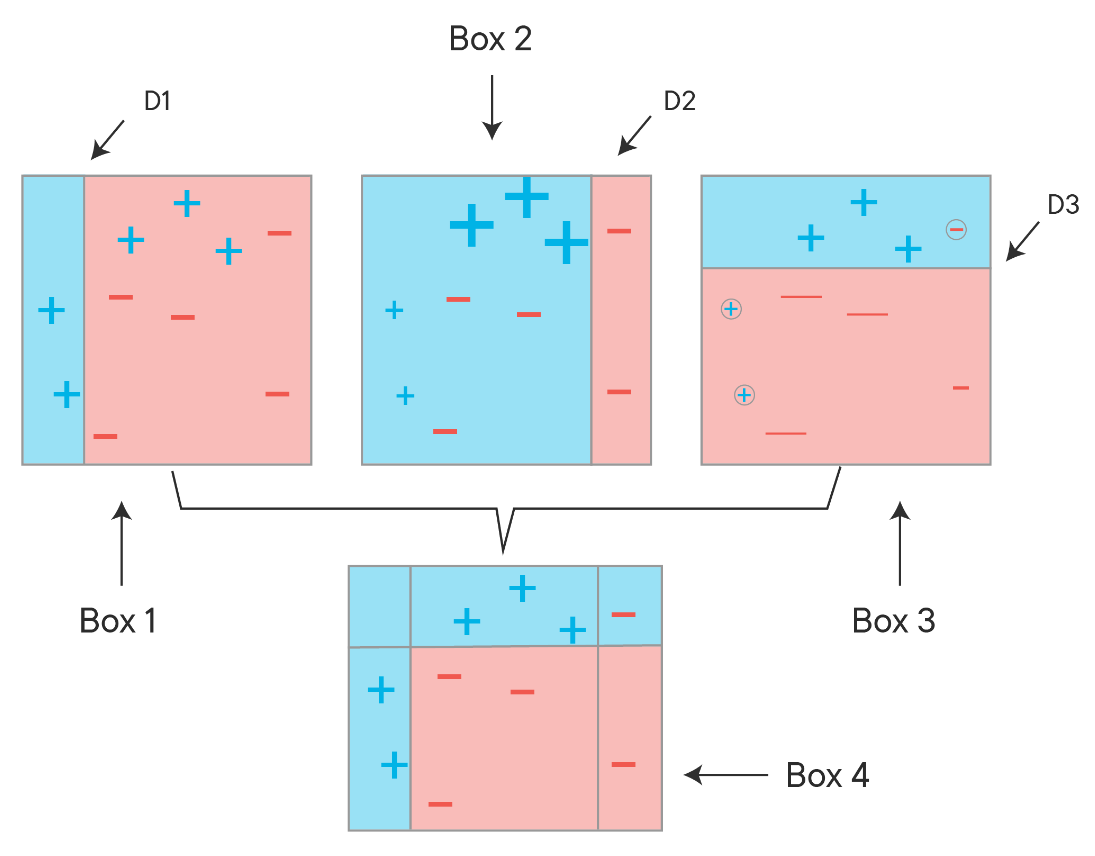

In [13]:
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []
        self.scores=[]

    def fit_ada(self, X, y,maxDepth, M = 100):
        self.alphas = [] 
        self.training_errors = []
        self.M = M
        for m in range(0, M):     
            print("....Inicializando vetor de pesos....")       
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)
            else:
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            print("Treinando o modelo....")
            G_m = DecisionTreeClassifier(max_depth = maxDepth) 
            G_m.fit(X, y, sample_weight = w_i)
            print(G_m)
            y_pred = G_m.predict(X)

            print("...:::: Avaliação ::::....  ")
            self.G_M.append(G_m) 
            # Calcula o erro #---------------------------------------------------------------------
            error_m = compute_error(y, y_pred, w_i)
            print('error '+str(error_m)) 
            self.training_errors.append(error_m)
            # Calcula o alpha #---------------------------------------------------------------------
            alpha_m = compute_alpha(error_m)
            print('alpha '+str(alpha_m))
            self.alphas.append(alpha_m)

            # Mostra a Matriz de Confusão #---------------------------------------------------------------------
            print()
            print("::  Matriz de Confusão :: ")
            print("")
            train_acc_score, train_precision_score, train_recall_score = printCM(y_train, y_pred)

            self.scores.append([maxDepth, m, train_acc_score, train_precision_score, train_recall_score, error_m, alpha_m, G_m])

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):
            weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 
            for m in range(self.M):
                y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
                weak_preds.iloc[:,m] = y_pred_m

            y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

            return y_pred

Para o experimento realiza-se 5 testes variando a profundidade máxima da árvore.

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.521
Recall : 1.0
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.46922532408356404
alpha 0.12325450382372902

::  Matriz de Confusão :: 

Confusion Matrix : 
[[143 123]
 [320 179]]
Total : 957.0
Acurácia : 0.42091503267973857
Misclassification rate : 0.463
True positives : 0.359
False positives : 0.462
Specificity : 0.538
Precision : 0.49401360551849266
Prevalence : 0.521
Recall : 0.359
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.46956110508249993
alpha 0.1219063280253294

::  Matriz de Confusão :: 

Confusion Matrix : 
[[204  62]
 [362 137]]
Total : 957.0
Acurácia : 0.44575163398692813
Misclassification rate : 0.443
True positives : 0.275
False positives : 0.233
Specificity : 0.767
Precision : 0.5743862154719183
Prevalence : 0.521
Recall : 0

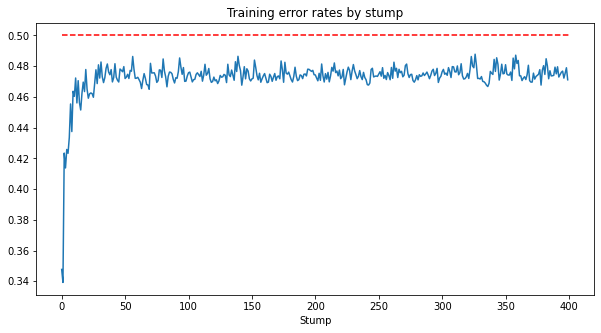

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.521
Recall : 0.551
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.4494899538074498
alpha 0.20273170125408452

::  Matriz de Confusão :: 

Confusion Matrix : 
[[205  61]
 [361 138]]
Total : 957.0
Acurácia : 0.44836601307189544
Misclassification rate : 0.441
True positives : 0.277
False positives : 0.229
Specificity : 0.771
Precision : 0.5782783754101579
Prevalence : 0.521
Recall : 0.277
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.451640102530526
alpha 0.19404618926046

::  Matriz de Confusão :: 

Confusion Matrix : 
[[ 87 179]
 [138 361]]
Total : 957.0
Acurácia : 0.5856209150326798
Misclassification rate : 0.331
True positives : 0.723
False positives : 0.673
Specificity : 0.327
Precision : 0.5705151295085935
Prevalence : 0.521
Recall : 0.723


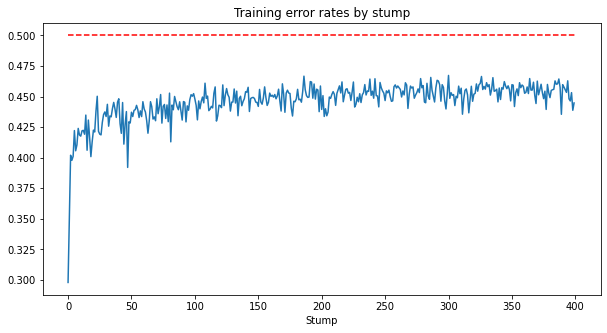

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.521
Recall : 0.643
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.2277597250996812
alpha 1.221004502522723

::  Matriz de Confusão :: 

Confusion Matrix : 
[[172  94]
 [162 337]]
Total : 957.0
Acurácia : 0.665359477124183
Misclassification rate : 0.268
True positives : 0.675
False positives : 0.353
Specificity : 0.647
Precision : 0.6890868097751996
Prevalence : 0.521
Recall : 0.675
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.25692183730000934
alpha 1.0620293343560703

::  Matriz de Confusão :: 

Confusion Matrix : 
[[195  71]
 [158 341]]
Total : 957.0
Acurácia : 0.7006535947712418
Misclassification rate : 0.239
True positives : 0.683
False positives : 0.267
Specificity : 0.733
Precision : 0.7319578973443297
Prevalence : 0.521
Recall : 0.683


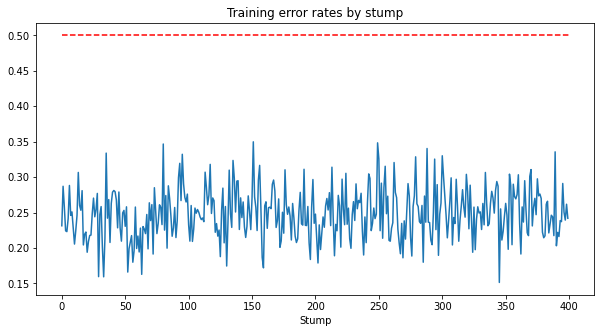

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.521
Recall : 0.854
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.04051603720033984
alpha 3.164697725197472

::  Matriz de Confusão :: 

Confusion Matrix : 
[[219  47]
 [ 59 440]]
Total : 957.0
Acurácia : 0.8614379084967321
Misclassification rate : 0.111
True positives : 0.882
False positives : 0.177
Specificity : 0.823
Precision : 0.8632531394862367
Prevalence : 0.521
Recall : 0.882
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.03656324175484182
alpha 3.2714634360774957

::  Matriz de Confusão :: 

Confusion Matrix : 
[[209  57]
 [113 386]]
Total : 957.0
Acurácia : 0.7777777777777778
Misclassification rate : 0.178
True positives : 0.774
False positives : 0.214
Specificity : 0.786
Precision : 0.7940480474585883
Prevalence : 0.521
Recall : 0.77

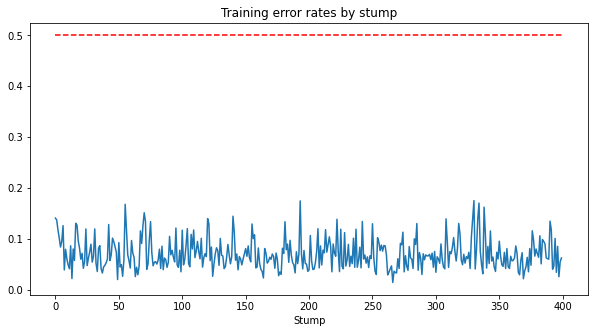

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.521
Recall : 0.912
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 3.174167829374201e-05
alpha 10.357848225782472

::  Matriz de Confusão :: 

Confusion Matrix : 
[[250  16]
 [ 18 481]]
Total : 957.0
Acurácia : 0.9555555555555556
Misclassification rate : 0.036
True positives : 0.964
False positives : 0.06
Specificity : 0.94
Precision : 0.9556469830592177
Prevalence : 0.521
Recall : 0.964
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 0.003241128154453763
alpha 5.728587421977707

::  Matriz de Confusão :: 

Confusion Matrix : 
[[240  26]
 [ 42 457]]
Total : 957.0
Acurácia : 0.9111111111111111
Misclassification rate : 0.071
True positives : 0.916
False positives : 0.098
Specificity : 0.902
Precision : 0.913100255005898
Prevalence : 0.521
Recall : 0.91

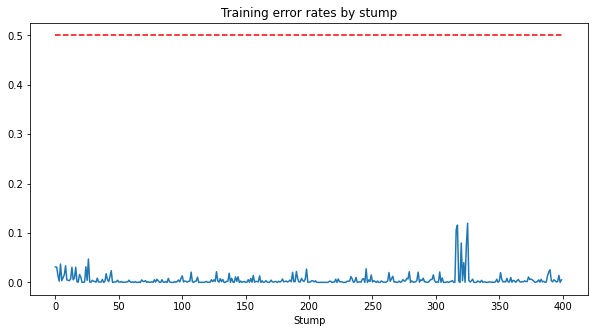

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.518
Recall : 0.177
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.47288603498759524
alpha 0.10856235892621897

::  Matriz de Confusão :: 

Confusion Matrix : 
[[165 104]
 [259 237]]
Total : 957.0
Acurácia : 0.5254901960784314
Misclassification rate : 0.379
True positives : 0.478
False positives : 0.387
Specificity : 0.613
Precision : 0.5874625836612518
Prevalence : 0.518
Recall : 0.478
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.4740391397886306
alpha 0.10393690804476856

::  Matriz de Confusão :: 

Confusion Matrix : 
[[169 100]
 [264 232]]
Total : 957.0
Acurácia : 0.5241830065359477
Misclassification rate : 0.38
True positives : 0.468
False positives : 0.372
Specificity : 0.628
Precision : 0.5903178715859679
Prevalence : 0.518
Recall : 0.4

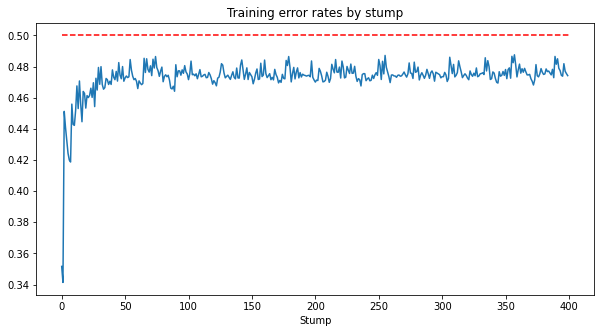

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.518
Recall : 0.73
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.4611030284966652
alpha 0.1559028979753642

::  Matriz de Confusão :: 

Confusion Matrix : 
[[103 166]
 [139 357]]
Total : 957.0
Acurácia : 0.6013071895424836
Misclassification rate : 0.319
True positives : 0.72
False positives : 0.617
Specificity : 0.383
Precision : 0.5922372878590095
Prevalence : 0.518
Recall : 0.72
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.4569780758137711
alpha 0.17251427955830492

::  Matriz de Confusão :: 

Confusion Matrix : 
[[258  11]
 [450  46]]
Total : 957.0
Acurácia : 0.39738562091503266
Misclassification rate : 0.482
True positives : 0.093
False positives : 0.041
Specificity : 0.959
Precision : 0.6513805561871888
Prevalence : 0.518
Recall : 0.093


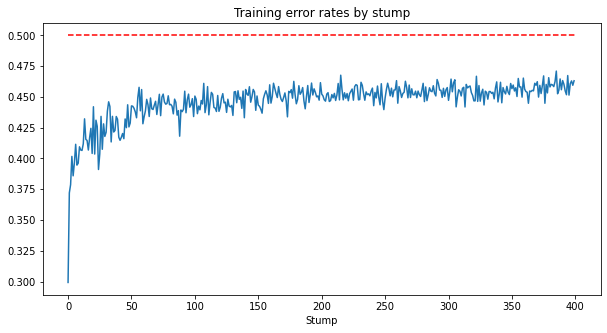

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.518
Recall : 0.673
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.2576399370037119
alpha 1.0582713684037663

::  Matriz de Confusão :: 

Confusion Matrix : 
[[194  75]
 [220 276]]
Total : 957.0
Acurácia : 0.6143790849673203
Misclassification rate : 0.308
True positives : 0.556
False positives : 0.279
Specificity : 0.721
Precision : 0.674601613220539
Prevalence : 0.518
Recall : 0.556
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.224042106847595
alpha 1.242264246121706

::  Matriz de Confusão :: 

Confusion Matrix : 
[[200  69]
 [149 347]]
Total : 957.0
Acurácia : 0.7150326797385621
Misclassification rate : 0.228
True positives : 0.7
False positives : 0.257
Specificity : 0.743
Precision : 0.742333983038517
Prevalence : 0.518
Recall : 0.7
....Ini

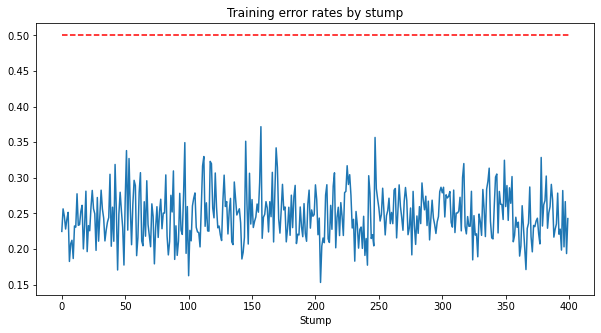

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.518
Recall : 0.79
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.12002973349393539
alpha 1.9921486276341336

::  Matriz de Confusão :: 

Confusion Matrix : 
[[194  75]
 [112 384]]
Total : 957.0
Acurácia : 0.7555555555555555
Misclassification rate : 0.195
True positives : 0.774
False positives : 0.279
Specificity : 0.721
Precision : 0.765355205262933
Prevalence : 0.518
Recall : 0.774
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.05110737305769441
alpha 2.9213668751945447

::  Matriz de Confusão :: 

Confusion Matrix : 
[[222  47]
 [ 95 401]]
Total : 957.0
Acurácia : 0.8143790849673203
Misclassification rate : 0.148
True positives : 0.808
False positives : 0.175
Specificity : 0.825
Precision : 0.8266001879195422
Prevalence : 0.518
Recall : 0.808

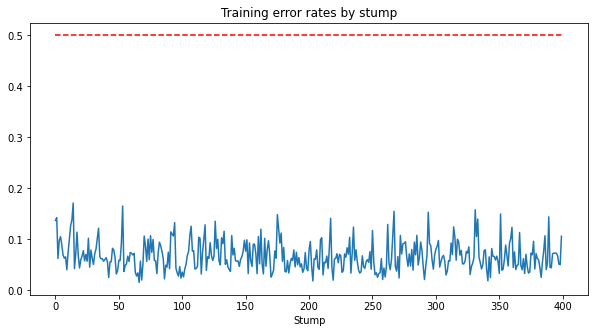

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.518
Recall : 0.788
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 0.0014282335717795622
alpha 6.549887608298671

::  Matriz de Confusão :: 

Confusion Matrix : 
[[238  31]
 [ 44 452]]
Total : 957.0
Acurácia : 0.9019607843137255
Misclassification rate : 0.078
True positives : 0.911
False positives : 0.115
Specificity : 0.885
Precision : 0.9035215689729483
Prevalence : 0.518
Recall : 0.911
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 0.009441446827708136
alpha 4.653159745093455

::  Matriz de Confusão :: 

Confusion Matrix : 
[[234  35]
 [ 97 399]]
Total : 957.0
Acurácia : 0.8274509803921568
Misclassification rate : 0.138
True positives : 0.804
False positives : 0.13
Specificity : 0.87
Precision : 0.8446656003791244
Prevalence : 0.518
Recall : 0.80

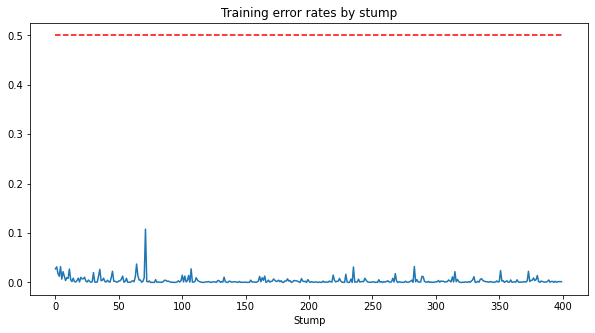

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.532
Recall : 0.348
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.4715342854732489
alpha 0.11398611485669151

::  Matriz de Confusão :: 

Confusion Matrix : 
[[  0 257]
 [  0 509]]
Total : 957.0
Acurácia : 0.664490861618799
Misclassification rate : 0.269
True positives : 1.0
False positives : 1.0
Specificity : 0.0
Precision : 0.44154810517489385
Prevalence : 0.532
Recall : 1.0
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.4726111603187745
alpha 0.10966513348287316

::  Matriz de Confusão :: 

Confusion Matrix : 
[[194  63]
 [367 142]]
Total : 957.0
Acurácia : 0.4386422976501306
Misclassification rate : 0.449
True positives : 0.279
False positives : 0.245
Specificity : 0.755
Precision : 0.5763042428737631
Prevalence : 0.532
Recall : 0.279
....I

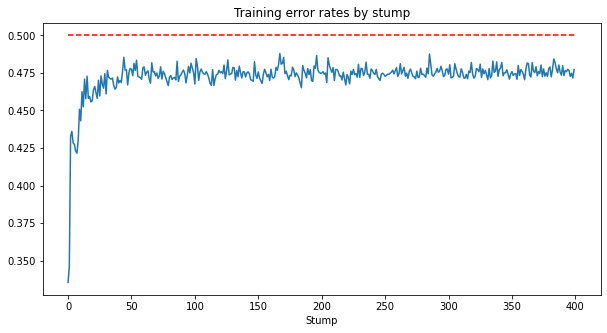

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.532
Recall : 0.635
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.45699492320204027
alpha 0.17244638756065572

::  Matriz de Confusão :: 

Confusion Matrix : 
[[156 101]
 [263 246]]
Total : 957.0
Acurácia : 0.5248041775456919
Misclassification rate : 0.38
True positives : 0.483
False positives : 0.393
Specificity : 0.607
Precision : 0.5959950736923185
Prevalence : 0.532
Recall : 0.483
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.45404316298270186
alpha 0.1843476533668207

::  Matriz de Confusão :: 

Confusion Matrix : 
[[103 154]
 [127 382]]
Total : 957.0
Acurácia : 0.6331592689295039
Misclassification rate : 0.294
True positives : 0.75
False positives : 0.599
Specificity : 0.401
Precision : 0.6238234556584769
Prevalence : 0.532
Recall : 0.75

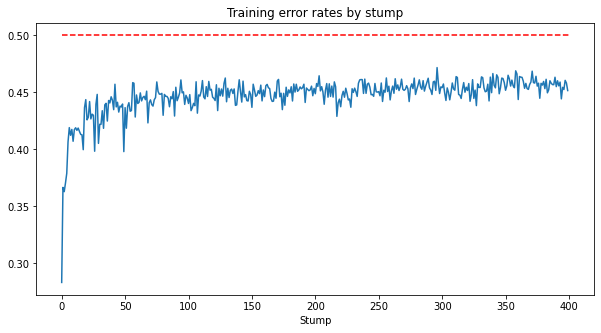

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.532
Recall : 0.617
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.26045884096713423
alpha 1.0435850899394745

::  Matriz de Confusão :: 

Confusion Matrix : 
[[164  93]
 [177 332]]
Total : 957.0
Acurácia : 0.6475195822454308
Misclassification rate : 0.282
True positives : 0.652
False positives : 0.362
Specificity : 0.638
Precision : 0.6804438597257698
Prevalence : 0.532
Recall : 0.652
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.21366673417901183
alpha 1.3029632206594792

::  Matriz de Confusão :: 

Confusion Matrix : 
[[140 117]
 [144 365]]
Total : 957.0
Acurácia : 0.6592689295039165
Misclassification rate : 0.273
True positives : 0.717
False positives : 0.455
Specificity : 0.545
Precision : 0.6685851161049045
Prevalence : 0.532
Recall : 0.7

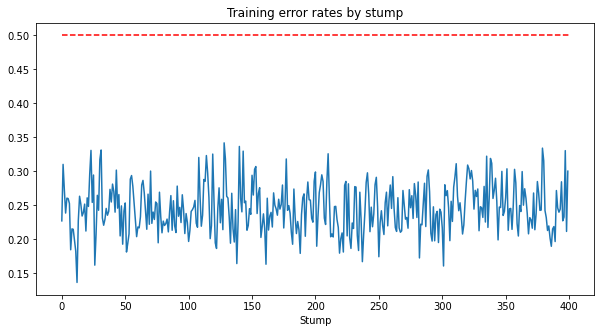

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.532
Recall : 0.735
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.031731540058330086
alpha 3.41819824271141

::  Matriz de Confusão :: 

Confusion Matrix : 
[[227  30]
 [ 98 411]]
Total : 957.0
Acurácia : 0.8328981723237598
Misclassification rate : 0.134
True positives : 0.807
False positives : 0.117
Specificity : 0.883
Precision : 0.8536276306063699
Prevalence : 0.532
Recall : 0.807
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.04743252168896563
alpha 2.999852842847108

::  Matriz de Confusão :: 

Confusion Matrix : 
[[189  68]
 [ 36 473]]
Total : 957.0
Acurácia : 0.8642297650130548
Misclassification rate : 0.109
True positives : 0.929
False positives : 0.265
Specificity : 0.735
Precision : 0.8627965811305821
Prevalence : 0.532
Recall : 0.929

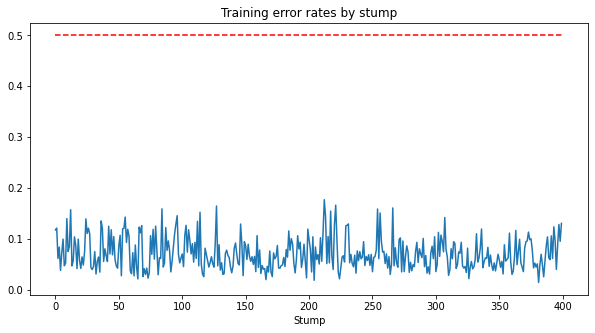

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.532
Recall : 0.925
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 0.007522241477132831
alpha 4.882340440445757

::  Matriz de Confusão :: 

Confusion Matrix : 
[[191  66]
 [ 85 424]]
Total : 957.0
Acurácia : 0.8028720626631853
Misclassification rate : 0.158
True positives : 0.833
False positives : 0.257
Specificity : 0.743
Precision : 0.8071700595324973
Prevalence : 0.532
Recall : 0.833
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 0.004348926231156972
alpha 5.433467897446694

::  Matriz de Confusão :: 

Confusion Matrix : 
[[225  32]
 [ 33 476]]
Total : 957.0
Acurácia : 0.9151436031331592
Misclassification rate : 0.068
True positives : 0.935
False positives : 0.125
Specificity : 0.875
Precision : 0.9152283483691382
Prevalence : 0.532
Recall : 0.9

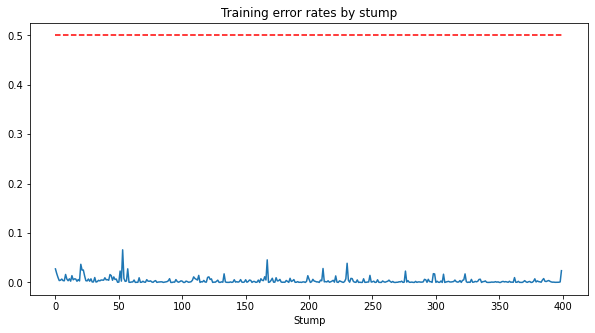

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.516
Recall : 1.0
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.4707295134347633
alpha 0.11721597034010199

::  Matriz de Confusão :: 

Confusion Matrix : 
[[146 126]
 [318 176]]
Total : 957.0
Acurácia : 0.42036553524804177
Misclassification rate : 0.464
True positives : 0.356
False positives : 0.463
Specificity : 0.537
Precision : 0.48757212354001445
Prevalence : 0.516
Recall : 0.356
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.47296845246198604
alpha 0.10823171968074419

::  Matriz de Confusão :: 

Confusion Matrix : 
[[209  63]
 [358 136]]
Total : 957.0
Acurácia : 0.45039164490861616
Misclassification rate : 0.44
True positives : 0.275
False positives : 0.232
Specificity : 0.768
Precision : 0.5716306307163115
Prevalence : 0.516
Recall : 0.

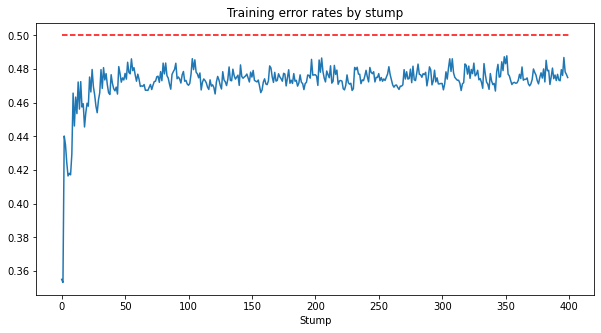

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.516
Recall : 0.342
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.45341812804658704
alpha 0.1868693881062007

::  Matriz de Confusão :: 

Confusion Matrix : 
[[130 142]
 [253 241]]
Total : 957.0
Acurácia : 0.48433420365535246
Misclassification rate : 0.413
True positives : 0.488
False positives : 0.522
Specificity : 0.478
Precision : 0.5263312177463887
Prevalence : 0.516
Recall : 0.488
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.44159257824173803
alpha 0.23470115417035153

::  Matriz de Confusão :: 

Confusion Matrix : 
[[ 83 189]
 [175 319]]
Total : 957.0
Acurácia : 0.5248041775456919
Misclassification rate : 0.38
True positives : 0.646
False positives : 0.695
Specificity : 0.305
Precision : 0.5192069678672521
Prevalence : 0.516
Recall : 0.

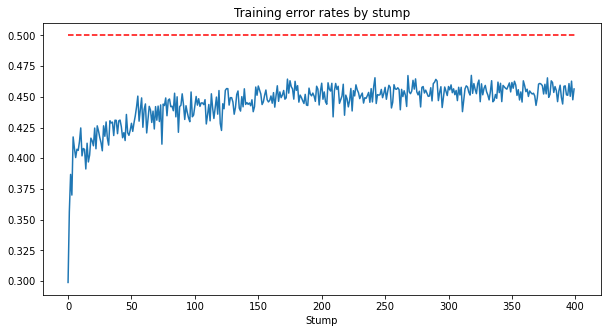

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.516
Recall : 0.524
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.24197466607520973
alpha 1.1418837721111008

::  Matriz de Confusão :: 

Confusion Matrix : 
[[213  59]
 [176 318]]
Total : 957.0
Acurácia : 0.6932114882506527
Misclassification rate : 0.246
True positives : 0.644
False positives : 0.217
Specificity : 0.783
Precision : 0.7384143444128313
Prevalence : 0.516
Recall : 0.644
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.2031948805278107
alpha 1.3664446101560999

::  Matriz de Confusão :: 

Confusion Matrix : 
[[188  84]
 [153 341]]
Total : 957.0
Acurácia : 0.6906005221932114
Misclassification rate : 0.248
True positives : 0.69
False positives : 0.309
Specificity : 0.691
Precision : 0.7132131817528738
Prevalence : 0.516
Recall : 0.69


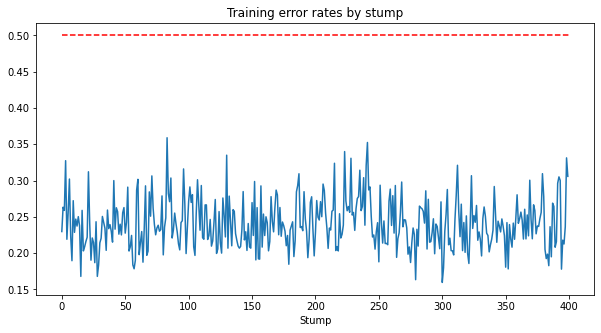

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.516
Recall : 0.777
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.07022341081887823
alpha 2.5832625877156894

::  Matriz de Confusão :: 

Confusion Matrix : 
[[211  61]
 [ 89 405]]
Total : 957.0
Acurácia : 0.804177545691906
Misclassification rate : 0.157
True positives : 0.82
False positives : 0.224
Specificity : 0.776
Precision : 0.8102368545889878
Prevalence : 0.516
Recall : 0.82
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.10258511185844177
alpha 2.168825470096115

::  Matriz de Confusão :: 

Confusion Matrix : 
[[165 107]
 [ 64 430]]
Total : 957.0
Acurácia : 0.7767624020887729
Misclassification rate : 0.179
True positives : 0.87
False positives : 0.393
Specificity : 0.607
Precision : 0.7722591422401219
Prevalence : 0.516
Recall : 0.87
...

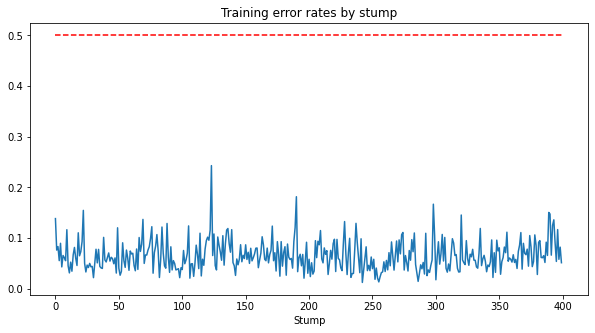

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.516
Recall : 0.856
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 0.00012872693048431892
alpha 8.957688479963021

::  Matriz de Confusão :: 

Confusion Matrix : 
[[250  22]
 [ 52 442]]
Total : 957.0
Acurácia : 0.9033942558746736
Misclassification rate : 0.077
True positives : 0.895
False positives : 0.081
Specificity : 0.919
Precision : 0.9082808735258536
Prevalence : 0.516
Recall : 0.895
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 0.0002013242950115671
alpha 8.510392197468445

::  Matriz de Confusão :: 

Confusion Matrix : 
[[253  19]
 [  8 486]]
Total : 957.0
Acurácia : 0.9647519582245431
Misclassification rate : 0.028
True positives : 0.984
False positives : 0.07
Specificity : 0.93
Precision : 0.9648520843801315
Prevalence : 0.516
Recall : 0.

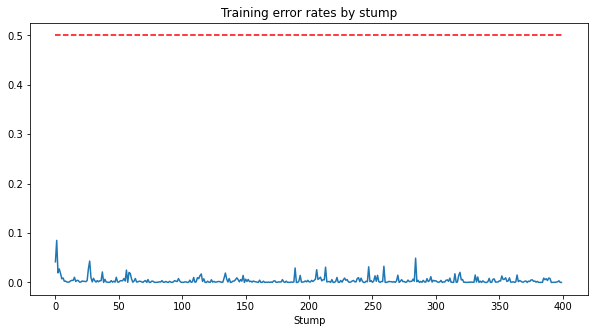

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.525
Recall : 0.269
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.47382781596905427
alpha 0.104784506986258

::  Matriz de Confusão :: 

Confusion Matrix : 
[[  0 264]
 [  0 502]]
Total : 957.0
Acurácia : 0.6553524804177546
Misclassification rate : 0.276
True positives : 1.0
False positives : 1.0
Specificity : 0.0
Precision : 0.42948687358970344
Prevalence : 0.525
Recall : 1.0
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=1)
...:::: Avaliação ::::....  
error 0.47477893319414977
alpha 0.10096996169377839

::  Matriz de Confusão :: 

Confusion Matrix : 
[[215  49]
 [388 114]]
Total : 957.0
Acurácia : 0.42950391644908614
Misclassification rate : 0.457
True positives : 0.227
False positives : 0.186
Specificity : 0.814
Precision : 0.5812289527071908
Prevalence : 0.525
Recall : 0.227
...

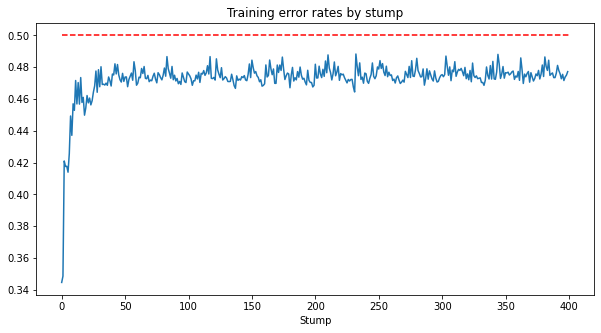

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.525
Recall : 0.155
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.4426546507933159
alpha 0.23039516761785542

::  Matriz de Confusão :: 

Confusion Matrix : 
[[ 82 182]
 [135 367]]
Total : 957.0
Acurácia : 0.5861618798955613
Misclassification rate : 0.331
True positives : 0.731
False positives : 0.689
Specificity : 0.311
Precision : 0.5683308422061316
Prevalence : 0.525
Recall : 0.731
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=2)
...:::: Avaliação ::::....  
error 0.45147237885258956
alpha 0.19472344147486728

::  Matriz de Confusão :: 

Confusion Matrix : 
[[154 110]
 [129 373]]
Total : 957.0
Acurácia : 0.6879895561357703
Misclassification rate : 0.25
True positives : 0.743
False positives : 0.417
Specificity : 0.583
Precision : 0.6936470694934073
Prevalence : 0.525
Recall : 0.7

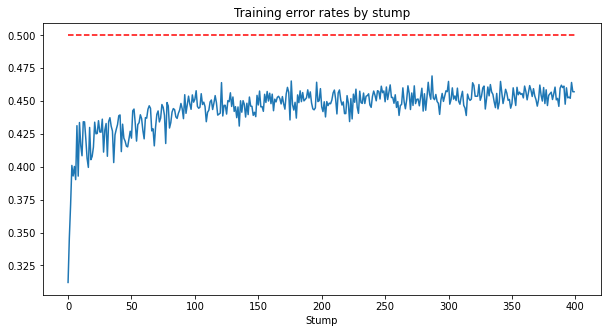

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.525
Recall : 0.761
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.24412342896297132
alpha 1.1302041432295793

::  Matriz de Confusão :: 

Confusion Matrix : 
[[193  71]
 [168 334]]
Total : 957.0
Acurácia : 0.6879895561357703
Misclassification rate : 0.25
True positives : 0.665
False positives : 0.269
Specificity : 0.731
Precision : 0.7247210652305773
Prevalence : 0.525
Recall : 0.665
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=4)
...:::: Avaliação ::::....  
error 0.21440797057075864
alpha 1.2985570064750311

::  Matriz de Confusão :: 

Confusion Matrix : 
[[208  56]
 [281 221]]
Total : 957.0
Acurácia : 0.5600522193211488
Misclassification rate : 0.352
True positives : 0.44
False positives : 0.212
Specificity : 0.788
Precision : 0.6694609842123613
Prevalence : 0.525
Recall : 0.44


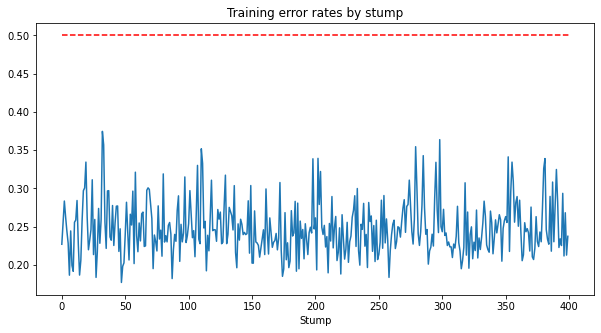

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.525
Recall : 0.801
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.08098145845713613
alpha 2.4290860774008673

::  Matriz de Confusão :: 

Confusion Matrix : 
[[149 115]
 [104 398]]
Total : 957.0
Acurácia : 0.7140992167101827
Misclassification rate : 0.229
True positives : 0.793
False positives : 0.436
Specificity : 0.564
Precision : 0.7114153365654521
Prevalence : 0.525
Recall : 0.793
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=6)
...:::: Avaliação ::::....  
error 0.048460144583883875
alpha 2.977339873835691

::  Matriz de Confusão :: 

Confusion Matrix : 
[[236  28]
 [116 386]]
Total : 957.0
Acurácia : 0.8120104438642297
Misclassification rate : 0.15
True positives : 0.769
False positives : 0.106
Specificity : 0.894
Precision : 0.8420996203377858
Prevalence : 0.525
Recall : 0.76

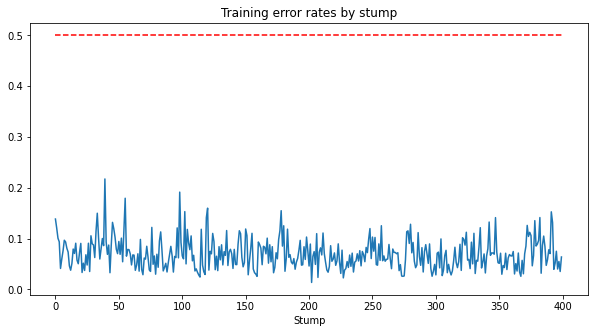

A saída de streaming foi truncada nas últimas 5000 linhas.
Prevalence : 0.525
Recall : 0.855
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 0.029458280402018405
alpha 3.4948793506940485

::  Matriz de Confusão :: 

Confusion Matrix : 
[[248  16]
 [ 23 479]]
Total : 957.0
Acurácia : 0.9490861618798956
Misclassification rate : 0.041
True positives : 0.954
False positives : 0.061
Specificity : 0.939
Precision : 0.9495663620296303
Prevalence : 0.525
Recall : 0.954
....Inicializando vetor de pesos....
Treinando o modelo....
DecisionTreeClassifier(max_depth=8)
...:::: Avaliação ::::....  
error 2.3552484808247815e-05
alpha 10.65625567827817

::  Matriz de Confusão :: 

Confusion Matrix : 
[[256   8]
 [ 16 486]]
Total : 957.0
Acurácia : 0.9686684073107049
Misclassification rate : 0.025
True positives : 0.968
False positives : 0.03
Specificity : 0.97
Precision : 0.9691136208608664
Prevalence : 0.525
Recall : 0.

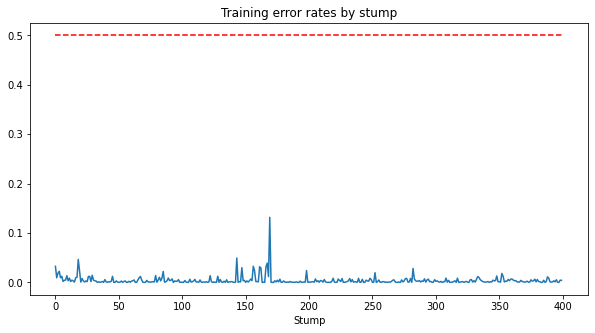

In [16]:
for train_indices, test_indices in kf.split(X):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    best_accuracy = 0
    for max in range(5):
        if max ==0:
          max=1
        else:
          max=max*2
        tree_reg = AdaBoost()
        tree_reg.fit_ada(X_train, y_train.ravel(),max ,M = 400)
        y_preds=tree_reg.predict(X_test)
        plt.figure(figsize=(10,5))
        plt.plot(tree_reg.training_errors)
        plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
        plt.title('Training error rates by stump')
        plt.xlabel('Stump')
        plt.show()


## Resultados

### Métricas

In [19]:
columns = ["n-fold","Model Idx","Acc","Precision", "Recall","Error", "Alpha", "Model"]

scoresDF = pd.DataFrame(tree_reg.scores, columns=columns)
scoresDF = scoresDF.sort_values(["Error"], ascending=False).reset_index(drop=True)
df_error = scoresDF.copy()


scoresDF.head(10)

n-fold  Model Idx       Acc  Precision  Recall     Error     Alpha  \
0       8        169  0.821149   0.822377   0.857  0.131765  1.885438   
1       8        143  0.744125   0.761437   0.749  0.049372  2.957750   
2       8         18  0.830287   0.838550   0.835  0.046542  3.019740   
3       8        167  0.832898   0.854752   0.801  0.039104  3.201644   
4       8        156  0.856397   0.858293   0.878  0.032733  3.386105   
5       8          0  0.967363   0.967904   0.966  0.032637  3.389125   
6       8        161  0.872063   0.883274   0.855  0.031729  3.418269   
7       8        166  0.882507   0.884870   0.894  0.031539  3.424489   
8       8        147  0.797650   0.806927   0.809  0.029946  3.477963   
9       8        162  0.949086   0.949566   0.954  0.029458  3.494879   

                                 Model  
0  DecisionTreeClassifier(max_depth=8)  
1  DecisionTreeClassifier(max_depth=8)  
2  DecisionTreeClassifier(max_depth=8)  
3  DecisionTreeClassifier(max_depth=8)  
4  DecisionTreeClassifier(max_depth=8)  
5  DecisionTreeClassifier(max_depth=8)  
6  DecisionTreeClassifier(max_depth=8)  
7  DecisionTreeClassifier(max_depth=8)  
8  DecisionTreeClassifier(max_depth=8)  
9  DecisionTreeClassifier(max_depth=8)

### Taxa de erro no treinamento


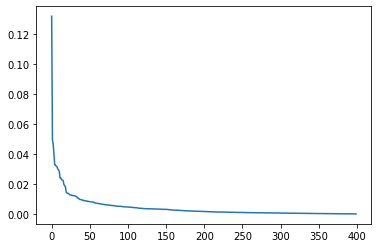

In [21]:
plt.figure()
plot1 = plt.plot(df_error.index.values, df_error["Error"])

## Conclusão
Durante a execução o erro de aprendizagem tende a diminuir enquanto as métricas levantadas começam a aumenta e a entrar em equilíbrio maximizando o desempendo do modelo executado.

Conclui-se que o medelo executou o que foi proposto, aumentou as métricas de forma equilibrada na medida que diminuiu a taxa de erro